<h1>Sentiment Analysis project<h1>
<h3>Name student: Sunday Awine<h3>
<h3>Student ID: 300391302<h3>


In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import nltk

In [15]:
# Load the dataset
file_path = "customer_review.tsv"
df = pd.read_csv(file_path, delimiter="\t")

1. Data Wraggling

In [16]:
# Display the first 10 rows
print(df.head(10))

   rating       date             variation  \
0       5  31-Jul-18      Charcoal Fabric    
1       5  31-Jul-18      Charcoal Fabric    
2       4  31-Jul-18        Walnut Finish    
3       5  31-Jul-18      Charcoal Fabric    
4       5  31-Jul-18      Charcoal Fabric    
5       5  31-Jul-18  Heather Gray Fabric    
6       3  31-Jul-18     Sandstone Fabric    
7       5  31-Jul-18      Charcoal Fabric    
8       5  30-Jul-18  Heather Gray Fabric    
9       5  30-Jul-18  Heather Gray Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  
5  I received the echo as a gift. I needed anothe...         1  
6  Without having a cellphone, I canno

In [17]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64


In [19]:
# Drop rows with missing values if any
df.dropna(inplace=True)

In [24]:
# Clean reviews: Remove stopwords
stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    return " ".join(words)

df['cleaned_verified_reviews'] = df['verified_reviews'].apply(remove_stopwords)


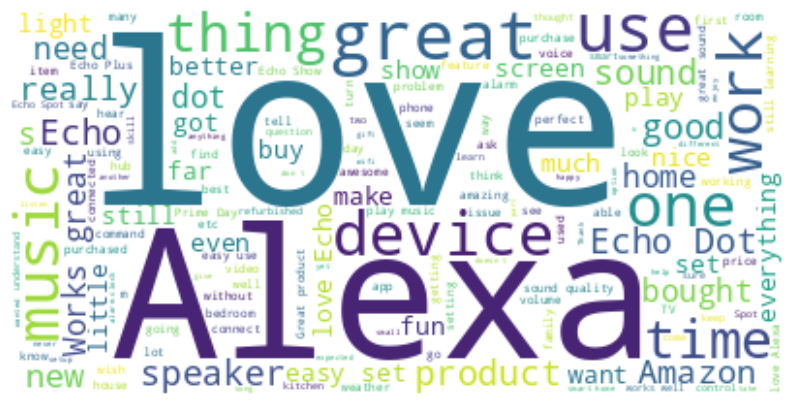

In [25]:
# Generate WordCloud
text = " ".join(review for review in df.cleaned_reviews)
wordcloud = WordCloud(background_color="white").generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

2. Data Engineering

In [ ]:
# Encode target labels
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['feedback'])

In [49]:
# Convert reviews to vector arrays
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_verified_reviews'])

In [50]:
# Convert text to sequences and pad them
X = tokenizer.texts_to_sequences(df['cleaned_verified_reviews'])
X = pad_sequences(X, padding='post')
y = pd.get_dummies(df['encoded_labels']).values

3. Model Design

In [43]:
# Define LSTM Model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                    output_dim=120,
                    input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [51]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 555, 120)            │         510,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 555, 120)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 176)                 │         209,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             354 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 720,042 (2.75 MB)

 Trainable params: 720,042 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

None


4. Data Spliting

In [56]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

5. Training the Model

In [57]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    verbose='auto',
                    validation_split=0.1)

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 55s 743ms/step - accuracy: 0.9340 - loss: 0.2426 - val_accuracy: 0.9484 - val_loss: 0.2119
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 81s 735ms/step - accuracy: 0.9135 - loss: 0.2958 - val_accuracy: 0.9484 - val_loss: 0.2124
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 84s 761ms/step - accuracy: 0.9232 - loss: 0.2704 - val_accuracy: 0.9484 - val_loss: 0.2049
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 80s 728ms/step - accuracy: 0.9252 - loss: 0.2674 - val_accuracy: 0.9484 - val_loss: 0.2092
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 80s 705ms/step - accuracy: 0.9185 - loss: 0.2843 - val_accuracy: 0.9484 - val_loss: 0.2117


6. Evaluate the Model

In [58]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step


In [74]:
# Map the numeric labels back to their original class names
target_names = [str(class_name) for class_name in label_encoder.classes_]

# Generate the classification report
report = classification_report(y_test_labels, y_pred_labels, target_names=target_names, zero_division=1)
print(report)


              precision    recall  f1-score   support

           0       1.00      0.00      0.00        63
           1       0.90      1.00      0.95       567

    accuracy                           0.90       630
   macro avg       0.95      0.50      0.47       630
weighted avg       0.91      0.90      0.85       630



7. Client Program

In [91]:
# Client program
def predict_feedback(verified_reviews):
    # Clean the review
    cleaned_verified_reviews = remove_stopwords(verified_reviews)

    # Convert to vector
    sequence = tokenizer.texts_to_sequences([cleaned_verified_reviews])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=X.shape[1])

    # Predict
    prediction = model.predict(padded_sequence)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]
# Test with a sample input
user_review = input("Enter your verified_review: ")
predicted_feedback = predict_feedback(user_review)
print("Predicted feedback:", predicted_feedback)

Enter your verified_review: Loved it!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted feedback: 1
